In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import shutil
import os
from turtle import title

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

from torchvision.io import read_image
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from pytorch_lightning import LightningDataModule

from efficientnet_pytorch import EfficientNet

from torchmetrics import MeanAbsoluteError as MAE
from torchmetrics import MeanMetric, MinMetric

from torchsampler import ImbalancedDatasetSampler

# Data preparation

In [2]:
class FaceDataset(Dataset):
    def __init__(
        self,
        img_dir="data/UTKFace/train",
        transform=None,
        target_transform=None,
    ):

        self.transform = transform
        self.target_transform = target_transform

        self.img_paths = []
        self.labels = []
        self.gender = [] # 0 (male) or 1 (female)
        self.race = [] # 0 to 4, denoting White, Black, Asian, Indian, and Others 

        for filename in os.listdir(img_dir):
            self.img_paths.append(os.path.join(img_dir, filename))
            self.labels.append(int(filename.split("_")[0]))

            self.gender.append(int(filename.split("_")[1]))

            self.race.append(int(filename.split("_")[2][0]))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = read_image(self.img_paths[idx])
        label = self.labels[idx]
        label = torch.FloatTensor([label])

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            label = self.target_transform(label)

        return img, label

    def get_labels(self):
        labels=self.labels
        if self.target_transform:
            labels = self.target_transform(labels)

        return labels

In [3]:
dataset = FaceDataset(img_dir="data/UTKFace")

In [4]:
df = pd.DataFrame({"age":dataset.labels,"race":dataset.race,"gender":dataset.gender,"path":dataset.img_paths})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     23708 non-null  int64 
 1   race    23708 non-null  int64 
 2   gender  23708 non-null  int64 
 3   path    23708 non-null  object
dtypes: int64(3), object(1)
memory usage: 741.0+ KB
None


In [5]:
df.age.max()

116

In [6]:
df["gender"]=df.gender.map({0:"Male",1:"Female"})

df["race"]=df.race.map({0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"})

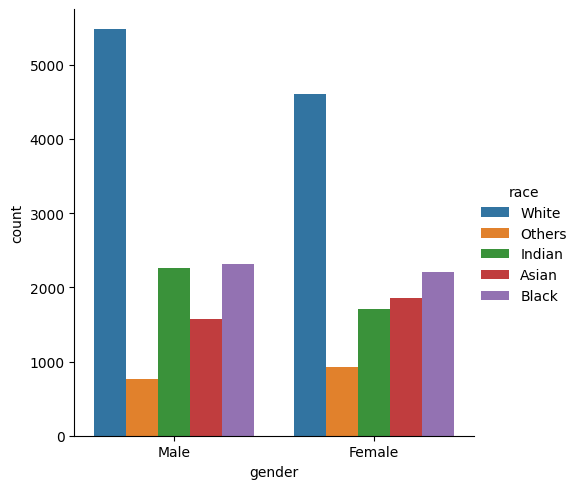

In [7]:
sns.catplot(data=df,x="gender",hue="race",kind="count")

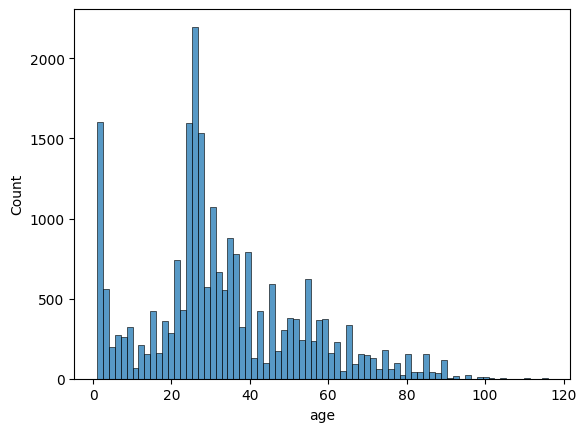

In [8]:
sns.histplot(data=df,x="age")
plt.savefig("age_distr.png")

<Axes: xlabel='age', ylabel='Count'>

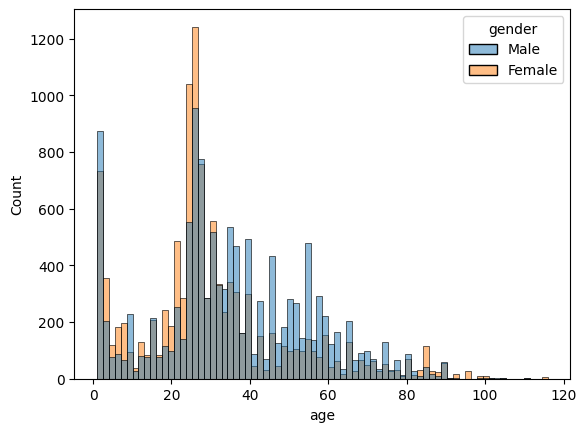

In [9]:
sns.histplot(data=df,x="age",hue="gender")

53
2
27
29
42


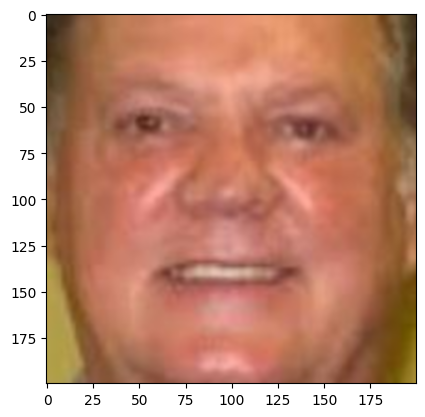

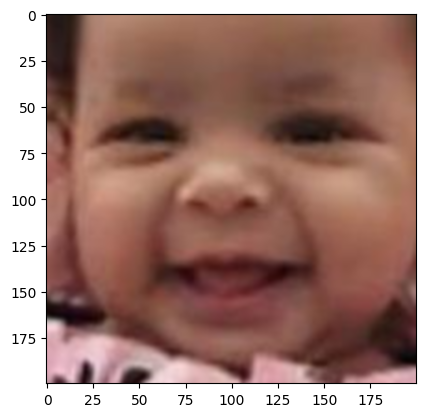

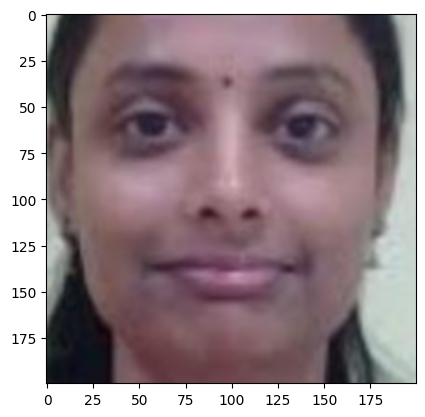

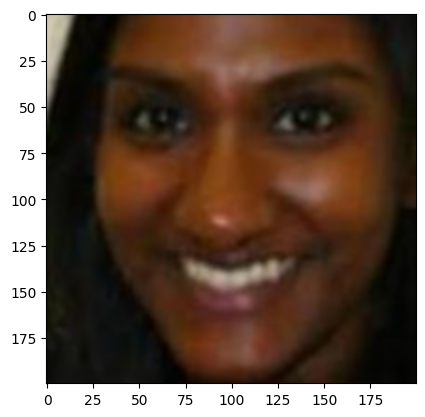

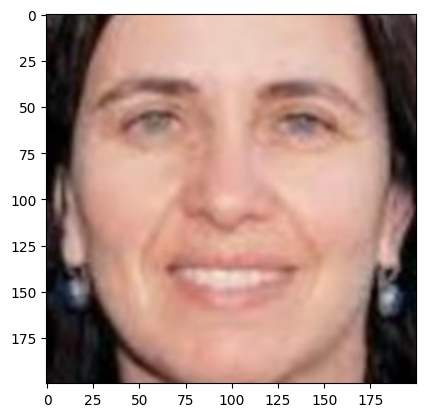

In [11]:
for i in range(5):
    img, label = dataset[i]
    plt.figure()
    print(int(label))
    plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")

In [9]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/test", exist_ok=True)

In [10]:
df=df.sort_values("age")

In [47]:
for i in range(10):
    if i==0:
        save_dir="data/test"
    elif i==1:
        save_dir="data/val"
    else:
        save_dir="data/train"

    for img in list(df[i::10]["path"]):
        shutil.copyfile(img,os.path.join(save_dir,img.split("/")[-1]))

In [15]:
len(os.listdir("data/val"))

2371

In [16]:
len(os.listdir("data/test"))

2371

In [17]:
len(os.listdir("data/train"))

18966

# Benchmark model

In [10]:
"""
VGG implementation from [InterDigitalInc](https://github.com/InterDigitalInc/HRFAE/blob/master/nets.py)
"""

class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        # vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.fc6 = nn.Linear(25088, 4096, bias=True)
        self.fc7 = nn.Linear(4096, 4096, bias=True)
        self.fc8_101 = nn.Linear(4096, 101, bias=True)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # input_w: 224                  
        # input_h: 224
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['p3'] = self.pool3(out['r33'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['p4'] = self.pool4(out['r43'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['p5'] = self.pool5(out['r53'])
        out['p5'] = out['p5'].view(out['p5'].size(0), -1)
        out['fc6'] = F.relu(self.fc6(out['p5']))
        out['fc7'] = F.relu(self.fc7(out['fc6']))
        out['fc8'] = self.fc8_101(out['fc7'])
        return out

# Our model

In [11]:
class PretrainedEfficientNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = EfficientNet.from_pretrained("efficientnet-b0", num_classes=1)

    def forward(self, x):
        x = self.model(x.float())
        return x

In [12]:
class LightningWrapper(pl.LightningModule):
    def __init__(self, net):
        
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        self.save_hyperparameters(ignore=['net'])
        
        # architecture
        self.net=net

        # loss function
        self.criterion = torch.nn.MSELoss()

        # metric objects for calculating and averaging MAE across batches
        self.train_mae = MAE()
        self.val_mae = MAE()
        self.test_mae = MAE()

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        # for tracking best so far validation accuracy
        self.val_mae_best = MinMetric()

        self.validation_step_outputs = []

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        return self.net(x)

    def model_step(self, batch):
        x, y = batch
        preds = self.forward(x)
        loss = self.criterion(preds, y)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.train_loss(loss)
        self.train_mae(preds, targets)
        self.log("train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train/mae", self.train_mae, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def on_train_start(self):
        self.val_mae_best.reset()

    def validation_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.val_loss(loss)
        self.val_mae(preds, targets)
        self.log("val/loss", self.val_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val/mae", self.val_mae, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_mae_best(self.val_mae.compute())
        self.log("val/mae_best", self.val_mae_best.compute(), prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, preds, targets = self.model_step(batch)

        self.test_loss(loss)
        self.test_mae(preds, targets)
        self.log("test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test/mae", self.test_mae, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

# Training

In [13]:
def clip_age(x):
    return np.clip(x, a_min=0,a_max=100)

In [14]:
class FaceDataModule(LightningDataModule):

    def __init__(
        self,
        data_dir: str = "data/",
        img_size: tuple = (224, 224),
        batch_size: int = 32,
        num_workers: int = 0,
        pin_memory: bool = False,
    ):
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters()

        self.data_train = None
        self.data_val = None
        self.data_test = None

    def setup(self, stage):
        if not self.data_train and not self.data_val and not self.data_test:

            # image transformations
            transform_list = []
            transform_list.append(transforms.Resize(self.hparams.img_size,antialias=True))
            transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
            transform_list.append(transforms.ColorJitter(brightness=0.2))
            transform = transforms.Compose(transform_list)

            # cap age
            target_transform=clip_age
            
            self.data_train = FaceDataset(
                img_dir="data/train",
                transform=transform,
                target_transform=target_transform
            )
            self.data_val = FaceDataset(
                img_dir="data/val",
                transform=transform,
                target_transform=target_transform
            )
            self.data_test = FaceDataset(
                img_dir="data/test",
                transform=transform,
                target_transform=target_transform
            )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.data_train,
            sampler=ImbalancedDatasetSampler(self.data_train),
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.hparams.batch_size,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            shuffle=False,
        )

In [15]:
net = PretrainedEfficientNet()

model = LightningWrapper(net=net)

Loaded pretrained weights for efficientnet-b0


In [16]:
data_dir = "data/"
log_dir = "logs/"

img_size = (224, 224)

datamodule = FaceDataModule(
    data_dir=data_dir,
    img_size=img_size,
    num_workers=6,
    batch_size=32,
    pin_memory=False,
)

In [17]:
callbacks = []
loggers = []

callbacks.append(
    pl.callbacks.ModelCheckpoint(
        monitor="val/loss",
        dirpath=log_dir + "checkpoints",
        save_top_k=1,
        save_last=True,
        mode="min",
        save_weights_only=True,
        filename="best-checkpoint",
    )
)

model_name=f"EffNet+{img_size}"
model_group=f"EffNet+{img_size}"

logger = TensorBoardLogger(log_dir, name=model_name)
logger2 = CSVLogger(log_dir, name=model_name)

loggers.append(
    logger
)

loggers.append(
    logger2
)

In [56]:
trainer = pl.Trainer(
        accelerator="gpu",
        default_root_dir=log_dir,
        callbacks=callbacks,
        logger=loggers,
        max_epochs=10,
        val_check_interval=0.1,  # frequency of validation epoch
    )

pl.seed_everything(123)
# validate before training
trainer.validate(model=model, datamodule=datamodule)

# train
trainer.fit(model=model, datamodule=datamodule)

# test
trainer.test(model=model, datamodule=datamodule, ckpt_path="best")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 123
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████████████| 75/75 [00:08<00:00,  8.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val/loss          │      60016.11328125       │
│          val/mae          │     175.7634735107422     │
│       val/mae_best        │     175.7634735107422     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | net          | PretrainedEfficientNet | 4.0 M 
1 | criterion    | MSELoss                | 0     
2 | train_mae    | MeanAbsoluteError      | 0     
3 | val_mae      | MeanAbsoluteError      | 0     
4 | test_mae     | MeanAbsoluteError      | 0     
5 | train_loss   | MeanMetric             | 0     
6 | val_loss     | MeanMetric             | 0     
7 | test_loss    | MeanMetric             | 0     
8 | val_mae_best | MinMetric              | 0     
--------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Epoch 0:  10%|██▏                   | 59/593 [00:26<03:55,  2.27it/s, v_num=4_5]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.18it/s]
Epoch 0:  20%|▏| 118/593 [01:01<04:07,  1.92it/s, v_num=4_5, val/loss=8.6e+6, va
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.20it/s]
Epoch 0:  30%|▎| 177/593 [01:36<03:46,  1.84it/s, v_num=4_5, val/loss=2.4e+5, va
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.26it/s]
Epoch 0:  40%|▍| 236/593 [02:11<03:18,  1.80it/s, v_num=4_5, val/loss=658.0, val
Validation: |                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████████████| 75/75 [00:09<00:00,  8.21it/s]
Epoch 0:  50%|▍| 295/593 [03

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█| 593/593 [11:39<00:00,  0.85it/s, v_num=4_5, val/loss=85.50, val


Restoring states from the checkpoint path at /home/olafw/Desktop/Age_Detector/logs/checkpoints/best-checkpoint.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/olafw/Desktop/Age_Detector/logs/checkpoints/best-checkpoint.ckpt


Testing DataLoader 0: 100%|█████████████████████| 75/75 [00:17<00:00,  4.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │     81.24903106689453     │
│         test/mae          │     6.726519584655762     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 81.24903106689453, 'test/mae': 6.726519584655762}]

# Results

In [18]:
results_train=pd.read_csv("logs/EffNet+(224, 224)/version_5/metrics.csv")

In [20]:
dataset = FaceDataset(img_dir="data/train/")

train_quantile=np.quantile(dataset.labels,0.5)

train_mean=np.mean(dataset.labels)

In [92]:
train_quantile

29.0

In [19]:
results_train

,epoch,step,val/mae_best,val/mae,val/loss,train/loss,train/mae,test/mae,test/loss
0,0,0,175.763474,175.763474,6.001611e+04,NaN,NaN,NaN,NaN
1,0,58,2726.781006,2726.781006,8.601399e+06,NaN,NaN,NaN,NaN
2,0,117,422.887360,422.887360,2.398166e+05,NaN,NaN,NaN,NaN
3,0,176,21.804289,21.804289,6.580508e+02,NaN,NaN,NaN,NaN
4,0,235,21.804289,22.620289,6.463777e+02,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
107,9,5808,6.540163,7.491669,8.913435e+01,NaN,NaN,NaN,NaN
108,9,5867,6.540163,6.736071,8.739606e+01,NaN,NaN,NaN,NaN
109,9,5926,6.540163,6.860487,8.547077e+01,NaN,NaN,NaN,NaN
110,9,5929,NaN,NaN,NaN,55.820202,5.650448,NaN,NaN


In [21]:
# %load_ext tensorboard

In [22]:
# %tensorboard --logdir logs/EffNet+\(224,\ 224\)

In [47]:
net_best = PretrainedEfficientNet()

model_best=LightningWrapper.load_from_checkpoint("logs/checkpoints/best-checkpoint.ckpt",net=net_best).eval()

Loaded pretrained weights for efficientnet-b0


In [48]:
model_best.to("cuda")

LightningWrapper(
  (net): PretrainedEfficientNet(
    (model): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_pad

In [63]:
datamodule.setup(0)

In [64]:
all_preds_best = []
all_targets_best = []
with torch.no_grad():
    for x, y in datamodule.test_dataloader():
    
        preds = model_best.forward(x.to("cuda"))
        preds = preds.detach()
        
        preds = preds.cpu().numpy()
        targets = y.cpu().numpy()
        
        all_preds_best.append(preds)
        all_targets_best.append(targets)

In [65]:
all_preds_best = np.concatenate(all_preds_best).astype(int).reshape(-1)
all_targets_best = np.concatenate(all_targets_best).astype(int).reshape(-1)

In [66]:
model_benchmark=VGG()
state_dict=torch.load("models/dex_imdb_wiki.pt")

In [67]:
state_dict["fc8_101.weight"] = state_dict.pop("fc8-101.weight")
state_dict["fc8_101.bias"] = state_dict.pop("fc8-101.bias")

In [68]:
model_benchmark.load_state_dict(state_dict)
model_benchmark.eval()
model_benchmark.to("cuda")

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512,

In [69]:
all_preds_benchmark = []
all_targets_benchmark = []
with torch.no_grad():
    for x, y in datamodule.test_dataloader():
        preds = model_benchmark.forward(x.float().to("cuda"))["fc8"].argmax(1)
        preds = preds.detach()
        
        preds = preds.cpu().numpy()
        targets = y.cpu().numpy()
        
        all_preds_benchmark.append(preds)
        all_targets_benchmark.append(targets)

In [70]:
all_preds_benchmark = np.concatenate(all_preds_benchmark).astype(int).reshape(-1)
all_targets_benchmark = np.concatenate(all_targets_benchmark).astype(int).reshape(-1)

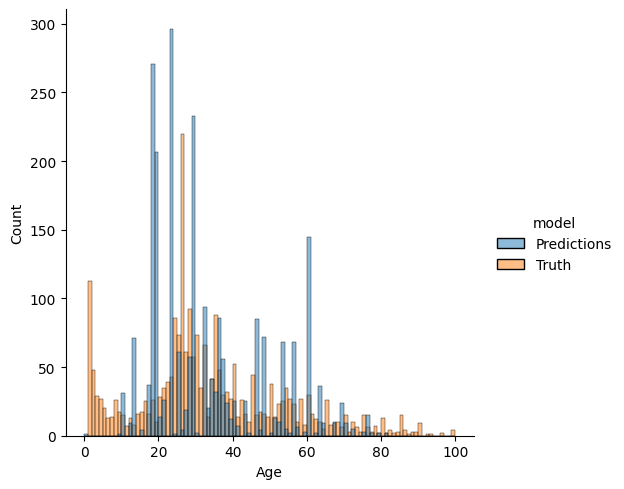

In [102]:
df=pd.DataFrame({"Age":np.concatenate([all_preds_benchmark,all_targets_benchmark]),"model":["Predictions"]*len(all_targets_benchmark)+["Truth"]*len(all_targets_benchmark)})

sns.displot(data=df, x="Age",hue="model", bins=100)
plt.savefig("vgg_distr.png")

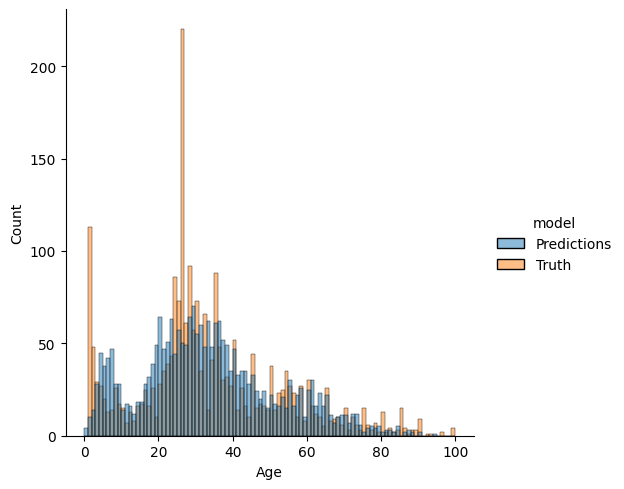

In [103]:
df=pd.DataFrame({"Age":np.concatenate([all_preds_best,all_targets_best]),"model":["Predictions"]*len(all_targets_best)+["Truth"]*len(all_targets_best)})

sns.displot(data=df, x="Age",hue="model", bins=100)
plt.savefig("eff_distr.png")

In [89]:
np.abs((all_preds_best-all_targets_best)).mean()

6.750316322226909

In [110]:
np.abs((all_preds_best[all_targets_best>=18]-all_targets_best[all_targets_best>=18])).mean()

7.258859784283513

In [106]:
np.abs((all_preds_benchmark-all_targets_benchmark)).mean()

11.52087726697596

In [108]:
np.abs((all_preds_benchmark[all_targets_benchmark>=18]-all_targets_benchmark[all_targets_benchmark>=18])).mean()

10.203389830508474

In [75]:
bemchmark_errors=np.sort(all_preds_benchmark-all_targets_benchmark)

In [76]:
bemchmark_errors

array([-80, -66, -55, ...,  68,  74,  77])

In [111]:
np.abs((train_quantile-all_targets_benchmark)).mean()

14.962884858709405

In [113]:
np.abs((train_quantile-all_targets_benchmark[all_targets_benchmark>=18])).mean()

13.281972265023112

In [77]:
quantile_errors=np.sort(29-all_targets_benchmark)

In [78]:
best_errors=np.sort(all_preds_best-all_targets_benchmark)

In [79]:
all_preds_best.shape

(2371,)

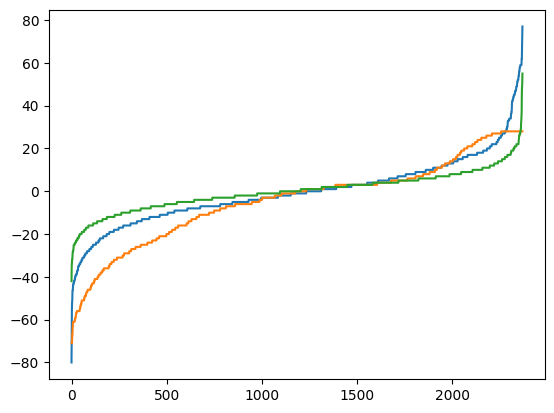

In [80]:
plt.plot(bemchmark_errors)
plt.plot(quantile_errors)
plt.plot(best_errors)

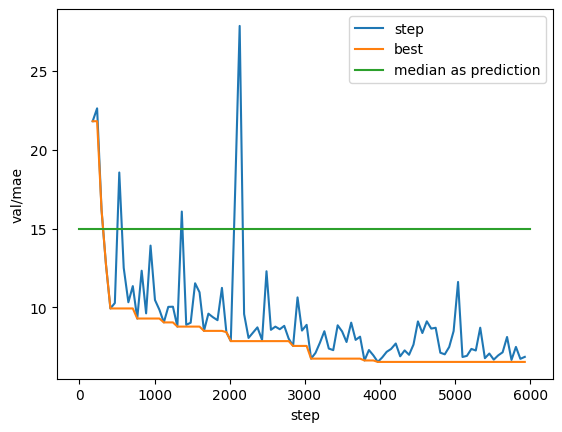

In [93]:
sns.lineplot(data=results_train[3:],x="step",y="val/mae",label="step")
sns.lineplot(data=results_train[3:],x="step",y="val/mae_best",label="best")
sns.lineplot(x=[0,6000],y=[15,15],label="median as prediction")
plt.savefig("train_mae.png")

# Failed example image to make younger

In [93]:
test_sample=dataset[500][0].reshape([1,3,200,200]).to('cuda').float().requires_grad_()

In [94]:
target_age=torch.tensor([[60.]]).to('cuda')

In [95]:
new_photo=test_sample
new_photo.retain_grad()
learning_rate=1.
model=model_best
for i in range(15):

    print(i)
    pred=model.forward(new_photo)
    model.criterion(pred,target_age).backward(retain_graph=True)
    
    new_photo=new_photo-new_photo.grad*learning_rate
    new_photo.grad=None
    model.net.zero_grad()
    new_photo.retain_grad()
    new_photo.requires_grad_()

    print(pred)

0
tensor([[31.8729]], device='cuda:0', grad_fn=<AddmmBackward0>)
1
tensor([[36.6235]], device='cuda:0', grad_fn=<AddmmBackward0>)
2
tensor([[38.8885]], device='cuda:0', grad_fn=<AddmmBackward0>)
3
tensor([[43.7487]], device='cuda:0', grad_fn=<AddmmBackward0>)
4
tensor([[55.3138]], device='cuda:0', grad_fn=<AddmmBackward0>)
5
tensor([[57.0513]], device='cuda:0', grad_fn=<AddmmBackward0>)
6
tensor([[57.8003]], device='cuda:0', grad_fn=<AddmmBackward0>)
7
tensor([[58.3157]], device='cuda:0', grad_fn=<AddmmBackward0>)
8
tensor([[58.6942]], device='cuda:0', grad_fn=<AddmmBackward0>)
9
tensor([[58.9797]], device='cuda:0', grad_fn=<AddmmBackward0>)
10
tensor([[59.1986]], device='cuda:0', grad_fn=<AddmmBackward0>)
11
tensor([[59.3681]], device='cuda:0', grad_fn=<AddmmBackward0>)
12
tensor([[59.5003]], device='cuda:0', grad_fn=<AddmmBackward0>)
13
tensor([[59.6040]], device='cuda:0', grad_fn=<AddmmBackward0>)
14
tensor([[59.6857]], device='cuda:0', grad_fn=<AddmmBackward0>)


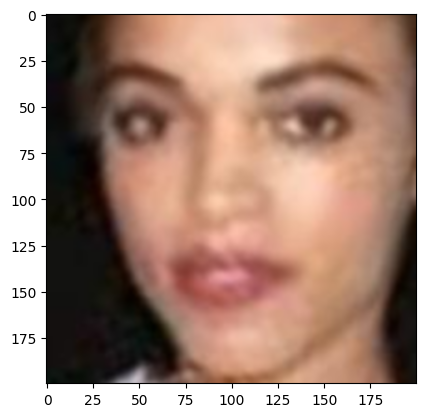

In [96]:
plt.imshow(transforms.ToPILImage()(test_sample.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

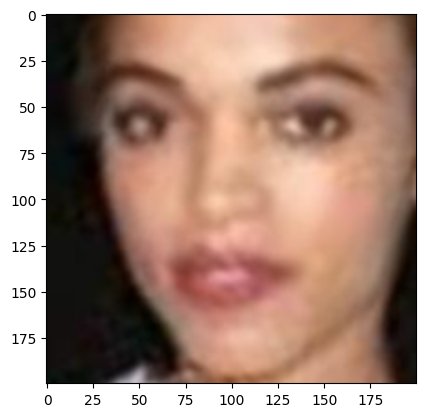

In [97]:
plt.imshow(transforms.ToPILImage()(new_photo.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

In [98]:
diff_photo=test_sample-new_photo

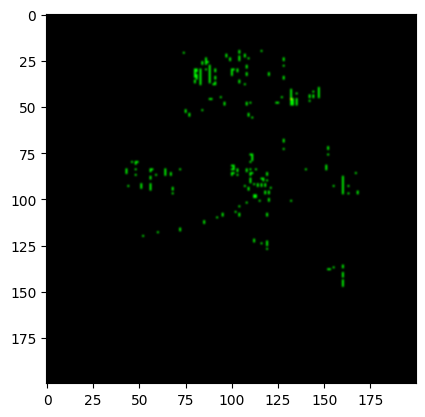

In [99]:
plt.imshow(transforms.ToPILImage()(diff_photo.reshape(3,200,200).to(torch.uint8)), interpolation="bicubic")

In [108]:
example=read_image("data/test/29_0_3_20170119153035762.jpg.chip.jpg")

example=transforms.Resize((224,224),antialias=True)(example)

model_best(example.reshape([1,3,224,224]).to('cuda').float())

tensor([[23.3674]], device='cuda:0', grad_fn=<AddmmBackward0>)

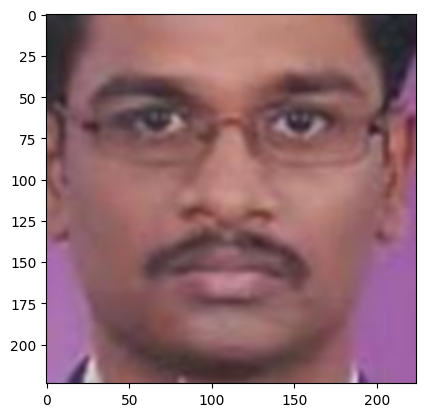

In [109]:
plt.imshow(transforms.ToPILImage()(example.reshape(3,224,224).to(torch.uint8)), interpolation="bicubic")